<a href="https://colab.research.google.com/github/fatimahaidara/NLP_wit_Disaster_Tweets/blob/main/svm_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf

tf.version.VERSION

'2.8.2'

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# Data Manipulation libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# NLP libraries
import string # Library for string operations
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re # Regex library
import demoji
from wordcloud import WordCloud # Word Cloud library

# ploting libraries
import matplotlib.pyplot as plt

# ML/AI libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

In [14]:
#@title
test_data = pd.read_csv("/content/test.csv")
train_data = pd.read_csv("/content/train.csv")

# Basic Info
print("Columns: ", list(train_data.columns))

# Features
X_train = train_data[["id", "keyword", "location", "text"]]
X_test = test_data

# Labels
y_train = train_data[["id","target"]]

print("Training Data Size", len(y_train))

train_data.head()

Columns:  ['id', 'keyword', 'location', 'text', 'target']
Training Data Size 7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

## Analyzing labels

In [15]:
Real_len = train_data[train_data['target'] == 1].shape[0]
Not_len = train_data[train_data['target'] == 0].shape[0]

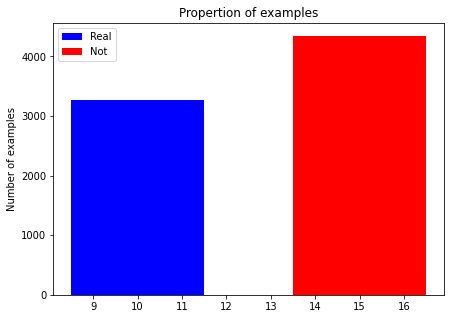

In [16]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

## Analyzing Features

### Sentence Length Analysis

In [17]:
def length(string):    
    return len(string)
train_data['length'] = train_data['text'].apply(length)

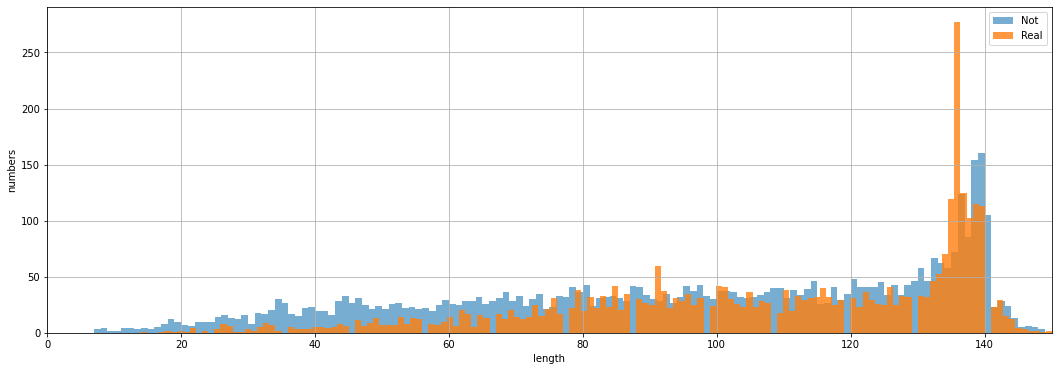

In [18]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train_data[train_data['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train_data[train_data['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

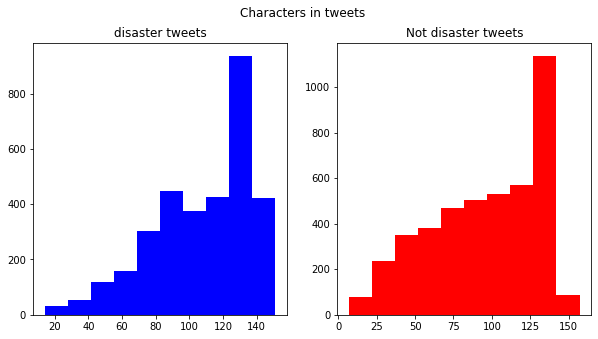

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

# Data Cleaning

**Data cleaning is the process of preparing data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted.**

1. Remove Url
2. Handle Tags
3. Handle emoji's
4. Remove HTML Tags
5. Remove stopwords
6. Removing Useless Characters

In [20]:
# Step 1. Remove Url
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580
def Remove_Url(string):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-)*\b', '', string)

# Step 2. Handle Tags
def Handle_Tags(string):
    pattern = re.compile(r'[@|#][^\s]+')
    matches = pattern.findall(string)
    tags = [match[1:] for match in matches]
    # Removing tags from main string
    string = re.sub(pattern, '', string)
    # More weightage to tag by adding them 3 times
    return string + ' ' + ' '.join(tags) + ' '+ ' '.join(tags) + ' ' + ' '.join(tags)

# Step 3. Handle emoji's
#http://unicode.org/Public/emoji/12.0/emoji-test.txt
demoji.download_codes()
def Handle_emoji(string):
    return demoji.replace_with_desc(string)

# Step 4. Remove HTML Tags
def Remove_html(string):
    return re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', str(string))

# Step 5. Remove Stopwords and Stemming
nltk.download('punkt')
nltk.download('stopwords')
stemmer  = SnowballStemmer('english')
stopword = stopwords.words('english')
def Remove_StopAndStem(string):
    string_list = string.split()
    return ' '.join([stemmer.stem(i) for i in string_list if i not in stopword])

# Step 6. Removing Useless Characters
def Remove_UC(string):
    thestring = re.sub(r'[^a-zA-Z\s]','', string)
    # remove word of length less than 2
    thestring = re.sub(r'\b\w{1,2}\b', '', thestring)
    #https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/
    return re.sub(' +', ' ', thestring) 

# Step7. Merging Other Details
def merging_details(data):
        #df = pd.DataFrame(columns=['id', 'Cleaned_data'])
        df_list = []
        
        #https://www.geeksforgeeks.org/how-to-iterate-over-rows-in-pandas-dataframe/
        for row in data.itertuples():
            df_dict = {}
            # Processing Keyword and location
            keyword = re.sub(r'[^a-zA-Z\s]','', str(row[2]))
            location = re.sub(r'[^a-zA-Z\s]','', str(row[3]))
            keyword = re.sub(r'\b\w{1,2}\b', '', keyword)
            location = re.sub(r'\b\w{1,2}\b', '', location)
            # Already processed data
            text = str(row[4])

            if keyword == 'nan':
                if location == 'nan':    
                    prs_data = text
                else:
                    prs_data = location + ' ' + text
            else:
                if location == 'nan':    
                    prs_data = keyword + ' ' + text
                else:
                    prs_data = keyword + ' ' + location + ' ' + text                
            
            prs_data = re.sub(' +', ' ', prs_data) 
            
            df_dict['Cleaned_data'] = prs_data
            
            df_list.append(df_dict)
                 
        return pd.DataFrame(df_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Final Pre-Processing Data

In [21]:
# Step 1. Remove Url
X_train['text'] = X_train['text'].apply(Remove_Url)
X_test['text'] = X_test['text'].apply(Remove_Url)

# Step 2. Handle Tags
X_train['text'] = X_train['text'].apply(Handle_Tags)
X_test['text'] = X_test['text'].apply(Handle_Tags)

# Step 3. Handle emoji's
X_train['text'] = X_train['text'].apply(Handle_emoji)
X_test['text'] = X_test['text'].apply(Handle_emoji)

# Step 4. Remove HTML Tags
X_train['text'] = X_train['text'].apply(Remove_html)
X_test['text'] = X_test['text'].apply(Remove_html)

# Step 5. Remove Stopwords and Stemming
X_train['text'] = X_train['text'].apply(Remove_StopAndStem)
X_test['text'] = X_test['text'].apply(Remove_StopAndStem)

# Step 6. Removing Useless Characters
X_train['text'] = X_train['text'].apply(Remove_UC)
X_test['text'] = X_test['text'].apply(Remove_UC)

# Step7. Merging Other Details
X_train = merging_details(X_train)
X_test = merging_details(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

## WORDCLOUD

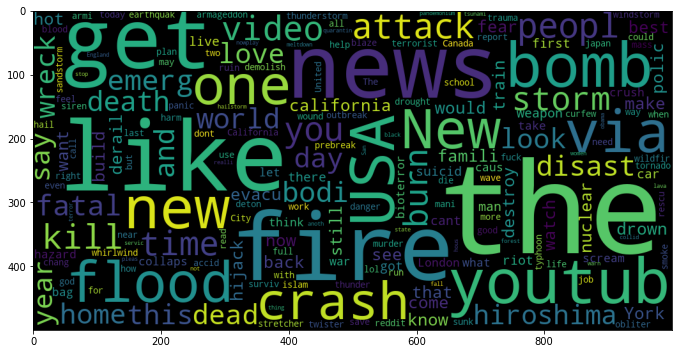

CPU times: user 1.69 s, sys: 169 ms, total: 1.86 s
Wall time: 1.85 s


In [22]:
%%time
dict_of_words = {}
for row in  X_train.itertuples():
    for i in row[1].split():
        try:
            dict_of_words[i] += 1
        except:
            dict_of_words[i] = 1

#Initializing  WordCloud
wordcloud = WordCloud(background_color = 'black', width=1000, height=500).generate_from_frequencies(dict_of_words)
fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.tight_layout(pad=1)
plt.show()

## Feature Extraction

In [23]:
%%time
#smooth_idf=True by default so smoothing is done by defult.
#norm is l2 by default.
#subliner is used False by default.
vectorizer = TfidfVectorizer(min_df = 0.0005, 
                             max_features = 100000, 
                             tokenizer = lambda x: x.split(),
                             ngram_range = (1,4))


X_train = vectorizer.fit_transform(X_train['Cleaned_data'])
X_test = vectorizer.transform(X_test['Cleaned_data'])

CPU times: user 1.38 s, sys: 61.4 ms, total: 1.44 s
Wall time: 1.55 s


## Classification using SVM

In [24]:
%%time
Model = svm.SVC(kernel='linear')
Model.fit(X_train, y_train['target'])
y_pred = Model.predict(X_test)
pred = y_pred.round().astype('int32')

CPU times: user 6.41 s, sys: 160 ms, total: 6.57 s
Wall time: 6.89 s


In [28]:
# creating submission.csv to publish results
submission = pd.read_csv('/content/sample_submission.csv')
submission['target'] = pred
submission.to_csv('submition_SVM.csv',index=False)